# Landslide Inventory and PRISM Climate Normals Data Processing

This notebook reads in the raw landslide inventory data from each source, subsets it to landslides with a known month, and summarizes the counts of landslides that occurred in each month in each inventory.  It creates Figure 1 and Table 1.

It also clips the PRISM 30-year climate normals and monthly precipitation data to each inventory footprint and summarizes the data.

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from rasterstats import zonal_stats
import rasterio as rio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
datadir = '../01_Data/'

In [3]:
figuredir = '../03_Figures/v3/'

    • NASA Global Landslide Catalog via  https://data.nasa.gov/Earth-Science/Global-Landslide-Catalog/h9d8-neg4 (accessed 2021-04-13). Open Database License. (NASA, 2018)  
    • Statewide Landslide Information Database for Oregon, release 4.2 (SLIDO-4.2) via https://www.oregongeology.org/pubs/dds/p-slido4.htm (accessed 2021-01-15). Public. (Franczyk et al., 2020)
    • Seattle Historic Landslide Locations ECA. https://data-seattlecitygis.opendata.arcgis.com/datasets/6ac72973a5784d90bda0a5f8a001d9f3_22/explore?location=47.616250%2C-122.328600%2C11.91 (accessed 2021-04-13). PDDL License. (City of Seattle, 2020) 
    • Washington Landslide Compilation. https://fortress.wa.gov/dnr/geologydata/publications/data_download/ger_portal_landslide_compilation.zip (accessed 2021-04-13). Public. (Washington Geological Survey, 2020)

Mean monthly precipitation over the landslide inventory footprints were calculated from the PRISM 30-year climate normals 1991-2020, available at https://prism.oregonstate.edu/normals/ (accessed 2022-02-14) and monthly PRISM AN81m (v M3, Ppt, July 2015) precipitation data, available at https://ftp.prism.oregonstate.edu/monthly/ppt/ (accessed 2022-08-18) (PRISM Climate Group, 2021)

In [4]:
#landslide inventory filenames
slido_fn = 'LandslideInventories/SLIDO/SLIDO-4_2_publication_bundle/SLIDO Release 4_2.gdb'
nasa_fn = 'LandslideInventories/NASA/nasa_global_landslide_catalog.gdb'
wlc_fn = 'LandslideInventories/WLC/ger_portal_landslide_compilation/landslide_compilation.gdb'
seattle_fn = 'LandslideInventories/SEATTLE/Historic_Landslide_Locations_ECA/Historic_Landslide_Locations_ECA.shp'


In [5]:
#footprint areas of each inventory in km^2

areas = {'seattle':371.0, #seattle city limits
         'slidoh':255014.0, #state of Oregon
         'wlc':184781.0, #state of Washington
         'nasa':439795.0, #combined states of Washington and Oregon
         'slidod':255014.0} #state of Oregon

## Read and reproject all inventories

In [6]:
#get NASA global landslide compilation (NASA)

nasa = gpd.read_file(datadir + nasa_fn, layer = 'nasa_global_landslide_catalog_point')

#subset to points in the states of Washington and Oregon 
nasa = nasa[nasa['admin_division_name'].isin(['Washington', 'Oregon'])].copy()

#reproject to NAD83/UTM10N
nasa = nasa.to_crs(epsg = 26910)

In [7]:
#get slido historical points "SLIDOh"

slidoh = gpd.read_file(datadir + slido_fn, layer = 'Historic_Landslide_Points')

#reproject to NAD83/UTM10N
slidoh = slidoh.to_crs(epsg = 26910)

In [8]:
#get slido deposits "SLIDOd"

slidod = gpd.read_file(datadir + slido_fn, layer = 'Deposits')

#reproject to NAD83/UTM10N
slidod = slidod.to_crs(epsg = 26910)

In [9]:
#get Seattle ECA

seattle = gpd.read_file(datadir + seattle_fn)

#reproject to NAD83/UTM10N
seattle = seattle.to_crs(epsg = 26910)

In [10]:
# get WLC

wlc = gpd.read_file(datadir + wlc_fn, layer = 'landslide_compilation')

#reproject to NAD83/UTM10N
wlc = wlc.to_crs(epsg = 26910)

## determine year, month, and day (where available) for each point/polygon

a '0' in any of these columns indicates that the value is unknown

In [11]:
#NASA
nasa['DATE'] = pd.to_datetime(nasa['event_date'])

nasa['YEAR'] = nasa['DATE'].dt.year
nasa['MONTH'] = nasa['DATE'].dt.month
nasa['DAY'] = nasa['DATE'].dt.day

nasa['YEAR'].fillna('0', inplace = True)
nasa['DAY'].fillna('0', inplace = True)  #fill nones with 0s 
nasa['MONTH'].fillna('0', inplace = True)
#year, month or day of 0 indicates unknown

nasa['YEAR'] = nasa['YEAR'].astype(int) #convert to integer
nasa['DAY'] = nasa['DAY'].astype(int)
nasa['MONTH'] = nasa['MONTH'].astype(int) #convert to integer

In [12]:
nasa[(nasa["MONTH"] == 7)& (nasa['YEAR'] == 2015)].to_csv(figuredir + 'nasajuly2015.csv')

In [13]:
#slidoh

slidoh['YEAR'].fillna('0', inplace = True)
slidoh['DAY'].fillna('0', inplace = True)  #fill nones with 0s 
slidoh['MONTH'].fillna('0', inplace = True)
#year, month or day of 0 indicates unknown

slidoh['YEAR'] = slidoh['YEAR'].astype(int) #convert to integer
slidoh['DAY'] = slidoh['DAY'].astype(int)
slidoh['MONTH'] = slidoh['MONTH'].astype(int) #convert to integer

In [14]:
#slidod

slidod['YEAR'].fillna('0', inplace = True)
slidod['DAY'].fillna('0', inplace = True)  #fill nones with 0s 
slidod['MONTH'].fillna('0', inplace = True)
#year, month or day of 0 indicates unknown

slidod['YEAR'] = slidod['YEAR'].astype(int) #convert to integer
slidod['DAY'] = slidod['DAY'].astype(int)
slidod['MONTH'] = slidod['MONTH'].astype(int) #convert to integer

In [15]:
#seattle

#fills the nans with 0s 

seattle['YEAR_'].fillna('0', inplace = True)
seattle['DAY_'].fillna('0', inplace = True)  #fill nones with 0s 
seattle['MONTH_'].fillna('0', inplace = True)
#year, month or day of 0 indicates unknown

seattle['YEAR'] = seattle['YEAR_'].astype(int) #convert to integer
seattle['DAY'] = seattle['DAY_'].astype(int)
seattle['MONTH'] = seattle['MONTH_'].astype(int) #convert to integer

#catch some strange values, set to 0 = unknown

seattle.loc[seattle['YEAR'] < 1800, 'YEAR'] = 0
seattle.loc[seattle['YEAR'] < 1800, 'MONTH'] = 0
seattle.loc[seattle['YEAR'] < 1800, 'DAY'] = 0


In [16]:
#wlc
wlc['DATE'] = pd.to_datetime(wlc['LANDSLIDE_DATE'])

wlc['YEAR'] = wlc['DATE'].dt.year
wlc['MONTH'] = wlc['DATE'].dt.month
wlc['DAY'] = wlc['DATE'].dt.day

wlc['YEAR'].fillna('0', inplace = True)
wlc['DAY'].fillna('0', inplace = True)  #fill nones with 0s 
wlc['MONTH'].fillna('0', inplace = True)
#year, month or day of 0 indicates unknown 

wlc['YEAR'] = wlc['YEAR'].astype(int) #convert to integer
wlc['DAY'] = wlc['DAY'].astype(int)
wlc['MONTH'] = wlc['MONTH'].astype(int) #convert to integer

In [17]:
#all reported landslides in WLC in 2007 or 2008 actually occurred during the December 3rd 2007 storm
#the LANDSLIDE_DATE field is occasionally used to record the mapping date

wlc.loc[wlc['YEAR'] == 2007, 'MONTH'] = 12
wlc.loc[wlc['YEAR'] == 2007, 'DAY'] = 3
wlc.loc[wlc['YEAR'] == 2008, 'DAY'] = 3
wlc.loc[wlc['YEAR'] == 2008, 'MONTH'] = 12
wlc.loc[wlc['YEAR'] == 2008, 'YEAR'] = 2007


wlc.loc[wlc['LANDSLIDE_TRIGGER_EVENT'] == 'December 3rd Storm', 'YEAR'] = 2007
wlc.loc[wlc['LANDSLIDE_TRIGGER_EVENT'] == 'December 3rd Storm', 'MONTH'] = 12
wlc.loc[wlc['LANDSLIDE_TRIGGER_EVENT'] == 'December 3rd Storm', 'DAY'] = 3




In [18]:
#drop the Mt. St. Helens event, since it introduces many zeros between 1980 and 2003 and isn't relevant
#for landslide seasonality

wlc = wlc[wlc['YEAR'] != 1980].copy()

In [19]:
wlc.groupby(['YEAR', 'MONTH', 'LANDSLIDE_TRIGGER_EVENT']).count()

LANDSLIDE_ID  LANDSLIDE_TYPE  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                                   
0    0                                        4204            3890   
2003 12    December 10th Storm, 2004             1               1   
2007 12    December 3rd Storm                  268             268   
           December 3rd storm event           1684            1684   
2009 1     January 2009 Storm                 1536            1536   
     4     April 2-3 rainstorm                   1               1   

                                      DSLS_MORPHOLOGY  LANDSLIDE_NAME  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                                      
0    0                                            179               1   
2003 12    December 10th Storm, 2004                1               0   
2007 12    December 3rd Storm                     268               0   
           December 3rd storm event              1684               0   
2009 1     January 2009 Storm                       5               0   
     4     April 2-3 rainstorm                      1               0   

                                      GRADIENT_DEGREES  GRADIENT_METHOD  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                                        
0    0                                            4204             4204   
2003 12    December 10th Storm, 2004                 0                1   
2007 12    December 3rd Storm                      245              268   
           December 3rd storm event               1676             1684   
2009 1     January 2009 Storm                     1536             1536   
     4     April 2-3 rainstorm                       1                1   

                                      SLOPE_MORPHOLOGY  ASPECT  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                               
0    0                                            4204    4204   
2003 12    December 10th Storm, 2004                 1       0   
2007 12    December 3rd Storm                      268       0   
           December 3rd storm event               1684      25   
2009 1     January 2009 Storm                     1536    1536   
     4     April 2-3 rainstorm                       1       0   

                                      GEOLOGIC_UNIT_LABEL  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                          
0    0                                               4204   
2003 12    December 10th Storm, 2004                    0   
2007 12    December 3rd Storm                         242   
           December 3rd storm event                  1683   
2009 1     January 2009 Storm                           0   
     4     April 2-3 rainstorm                          0   

                                      STRUCTURE_ASSOCIATION  ...  COMMENTS  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                           ...             
0    0                                                    0  ...      3435   
2003 12    December 10th Storm, 2004                      1  ...         0   
2007 12    December 3rd Storm                           268  ...        70   
           December 3rd storm event                    1684  ...        98   
2009 1     January 2009 Storm                             0  ...       164   
     4     April 2-3 rainstorm                            1  ...         1   

                                      FEATURE_SOURCE  SOURCE_INFORMATION  \
YEAR MONTH LANDSLIDE_TRIGGER_EVENT                                         
0    0                                          4204                4204   
2003 12    December 10th Storm, 2004               1                   1   
2007 12    December 3rd Storm                    268                 268   
           December 3rd storm event             1684                1684   
2009 1     January 2009 Storm                   1536                1536   
     4     April 2-3 rainstorm                     1                   1   

                                      S

## add indicator of which inventory each point is from, and an ID from that inventory

allows individual points to be traced back to the original inventory

In [20]:
nasa['inventory'] = 'nasa'
slidoh['inventory'] = 'slidoh'
slidod['inventory'] = 'slidod'
seattle['inventory'] = 'seattle'
wlc['inventory'] = 'wlc'

In [21]:
nasa['inv_id_name'] = 'event_id'
nasa['inv_id'] = nasa['event_id']

slidoh['inv_id_name'] = 'UNIQUE_ID'
slidoh['inv_id'] = slidoh['UNIQUE_ID']

slidod['inv_id_name'] = 'UNIQUE_ID'
slidod['inv_id'] = slidod['UNIQUE_ID']

seattle['inv_id_name'] = 'OBJECTID'
seattle['inv_id'] = seattle['OBJECTID']

wlc['inv_id_name'] = 'LANDSLIDE_ID'
wlc['inv_id'] = wlc['LANDSLIDE_ID']

## Simplify and combine

In [22]:
#specify which columns to keep (same for each inventory)

keep = ['geometry', 'YEAR', 'MONTH', 'DAY', 'inventory',
       'inv_id_name', 'inv_id']

In [23]:
#keep only those columns, create simplified dataframe for each inventory
nasas = nasa[keep]
slidohs = slidoh[keep]
slidods = slidod[keep]
seattles = seattle[keep]
wlcs = wlc[keep]

In [24]:
#combine into a single, tidy dataframe containing all of the landslides
#present in all of the inventories

slides = gpd.GeoDataFrame(data = pd.concat([nasas,
                                            slidohs,
                                            slidods,
                                            seattles,
                                            wlcs]), 
                                             crs = "EPSG:26910") #set crs for new geodataframe to NAD83/UTM10N



In [25]:
#pickle for later use
#slides.to_pickle(datadir + 'slides.pkl')
slides.to_pickle(figuredir + 'slides.pkl')

In [26]:
slides = pd.read_pickle(datadir + 'slides.pkl')

## Subset to landslides with known month

In [27]:
slidesm = slides.loc[(slides['MONTH'] > 0)].copy()

In [28]:
#get only centroids of polygons for consistent plotting

slidesm['geometry'] = slidesm['geometry'].centroid

## Calculate landslide counts by month and inventory

In [29]:
#group by year, month, and inventory and take count of points
slidesperminv = pd.DataFrame(slidesm.groupby(['YEAR', 'MONTH', 'inventory']).count()['geometry'])

slidesperminv.columns = ['counts']

#now we have all of the months that have more than 0 counts, but need to fill in the months with 0 counts

In [30]:
#set up a datetime index

#this creates a datetime index to be able to use pandas datetime index
#NOTE: although it now looks like all landslides occurred on the first day of the month, this is not the case!
#These landslides occurred sometime during that month

dtidx = pd.DataFrame({'year':slidesperminv.index.get_level_values('YEAR').values.astype(str),
               'month':slidesperminv.index.get_level_values('MONTH').values.astype(str),
               'day': np.ones_like(slidesperminv.index.get_level_values('MONTH').values).astype(str)})


In [31]:
#make a new dataframe with the date time index
slidesmi = pd.DataFrame({'inventory': slidesperminv.index.get_level_values('inventory').values, 
                  'counts':slidesperminv['counts'].values}, 
                index = pd.to_datetime(dtidx).values)

In [32]:
#loop through the inventories in this dataframe, adding zeros for the months with no landslide counts

#resulting dataframe has all months within the time range covered by each inventory with respective counts

invnames = slidesmi['inventory'].unique()

slidesallmi = slidesmi[slidesmi['inventory']==invnames[0]].resample('M').sum()
slidesallmi['inventory'] = invnames[0]

# add the ln(footprint area / 100000 km2) for each inventory 
#(to account for footprint area in the negative binomial model)
slidesallmi['ln_area'] = np.log(areas[invnames[0]]/100000)

for i in range(len(invnames)-1):
    temp = slidesmi[slidesmi['inventory']==invnames[i+1]].resample('M').sum()
    temp['inventory'] = invnames[i+1]
    temp['ln_area'] = np.log(areas[invnames[i+1]]/100000)
    slidesallmi = slidesallmi.append(temp)
    del temp

slidesallmi['month'] = slidesallmi.index.month

/tmp/ipykernel_16994/2860385964.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallmi = slidesallmi.append(temp)
/tmp/ipykernel_16994/2860385964.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallmi = slidesallmi.append(temp)
/tmp/ipykernel_16994/2860385964.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallmi = slidesallmi.append(temp)
/tmp/ipykernel_16994/2860385964.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallmi = slidesallmi.append(temp)


In [33]:
# rearrange columns
slidesallmi = slidesallmi[['month', 'inventory', 'counts', 'ln_area']]



In [34]:
#save to csv to read into R later

slidesallmi.to_csv(figuredir + 'slidesallmi.csv')


## Calculate counts by year and inventory for figure 1

In [35]:
slidesallyi = slidesmi[slidesmi['inventory']==invnames[0]].resample('Y').sum()
slidesallyi['cumulpct'] = slidesallyi.cumsum()/slidesallyi['counts'].sum()
slidesallyi['inventory'] = invnames[0]

for i in range(len(invnames)-1):
    temp = slidesmi[slidesmi['inventory']==invnames[i+1]].resample('Y').sum()
    temp['cumulpct'] = temp.cumsum()/temp['counts'].sum()
    temp['inventory'] = invnames[i+1]
    slidesallyi = slidesallyi.append(temp)
    del temp

/tmp/ipykernel_16994/986941468.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallyi = slidesallyi.append(temp)
/tmp/ipykernel_16994/986941468.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallyi = slidesallyi.append(temp)
/tmp/ipykernel_16994/986941468.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallyi = slidesallyi.append(temp)
/tmp/ipykernel_16994/986941468.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slidesallyi = slidesallyi.append(temp)


## Make figure 1

In [36]:
#read in shapefiles of the states of washington and oregon and the footprint areas

states = gpd.read_file(datadir + 'Footprints/tl_2017_us_state/tl_2017_us_state.shp')

#reproject to NAD83/UTM10N
states = states.to_crs(epsg = 26910)

#get Washington

WA = states[states['NAME']=='Washington'].copy()

#get Oregon
OR = states[states['NAME']=='Oregon'].copy()

#get Washington and Oregon
WAOR = states[states['NAME'].isin(['Washington', 'Oregon'])].copy()
              
#read Seattle
seattlelimits = gpd.read_file(datadir + 'Footprints/Municipal_Boundaries/Municipal_Boundaries.shp')

#subset to seattle
seattlelimits = seattlelimits[seattlelimits['CITYNAME']=='Seattle'].copy()

#reproject to NAD83/UTM10N
seattlelimits = seattlelimits.to_crs(epsg = 26910)



In [37]:
#log(x+1) transformation to be able to plot box plots on a log scale
slidesallmi['countsp1'] = slidesallmi['counts'] + 1

In [38]:
inv_names = ['nasa','slidoh','slidod','seattle','wlc']
footprintvecs = dict(zip(inv_names, [WAOR, OR, OR, seattlelimits, WA]))
labelnames = ['NASA GLC', 'SLIDOh', 'SLIDOd', 'Seattle', 'WLC']
cmap = ['#33BBEE', '#009988', '#EE7733', '#CC3311', '#EE3377']

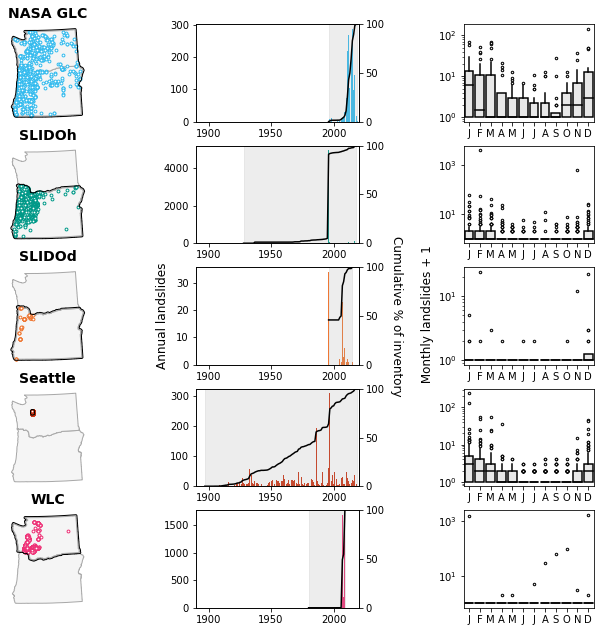

In [39]:



fig, ax = plt.subplots(5, 3, figsize = (21*(1/2.54),22*(1/2.54)), gridspec_kw = {'width_ratios': [0.8,1.5,1.2]})


#plot map of landslide points

for i in range(len(ax)):

    WAOR.plot(ax = ax[i][0],
                facecolor = '#F5F5F5',
                edgecolor = 'darkgrey')
    
    
    footprint = footprintvecs[inv_names[i]]
    
    footprint['dissolve'] = 1
    
    footprintbuffer = footprint.dissolve(by = 'dissolve').buffer(10000)
    

    #plot slides with known month
    slidesm.loc[(slidesm['inventory'] == inv_names[i])].plot(ax = ax[i][0], 
                                             edgecolor = cmap[i], 
                                             facecolor = 'white',
                                             markersize = 8, 
                                             alpha = 1)
    footprintbuffer.plot(ax = ax[i][0],
                         facecolor = 'None',
                          edgecolor = 'black')
    
    ax[i][0].set_axis_off()
    
    ax[i][0].set_title(labelnames[i],
                       fontweight = 'semibold', 
                       fontsize = 14)


#plot bar plot time series of landslide counts and cumulative % of landslides per year

for i in range(len(ax)):
    # Add x-axis and y-axis
    ax[i][1].bar(x = slidesallyi[slidesallyi['inventory'] == inv_names[i]].index.year,
              height = slidesallyi[slidesallyi['inventory'] == inv_names[i]]['counts'].values,
              width = 0.8,
              color=cmap[i])
    
    
    ax[i][1].axvspan(xmin = slidesallyi[slidesallyi['inventory'] == inv_names[i]].index.year.min(),
                  xmax = slidesallyi[slidesallyi['inventory'] == inv_names[i]].index.year.max(), 
                 color = 'darkgrey', 
                 alpha = 0.2)
    
    
    ax2 = ax[i][1].twinx()
    
    ax2.plot(slidesallyi[slidesallyi['inventory'] == inv_names[i]].index.year,
             slidesallyi[slidesallyi['inventory'] == inv_names[i]]['cumulpct'].values, 
              color = 'black')
    
    if i == 2: 
        ax2.set_ylabel('Cumulative % of inventory', 
                      rotation = 270, 
                      fontsize = 12, 
                       labelpad = 18)#, 
                      #fontweight = 'semibold')
    else:
        pass

    ax2.set_ylim(0,1)
    
    ax2.set_yticks([0,0.5,1])
    ax2.set_yticklabels([0,50,100])

    ax[i][1].set_xlim(xmin = 1890, xmax = 2020)
    
    ax[2][1].set_ylabel('Annual landslides', fontsize = 12, labelpad = -5)#, fontweight = 'semibold')

    #ax[4][1].set_xlabel("Year", fontsize = 12)#, fontweight = "semibold")

    
# plot boxplots of monthly counts 

for i in range(len(ax)):
    
    sns.boxplot(x = "month", y = "countsp1", 
                data = slidesallmi[slidesallmi['inventory'] == inv_names[i]], 
               color = '#E8E8E8', 
               showcaps = False, 
                ax = ax[i][2],
               **{'flierprops': dict(marker = ".", markeredgecolor = 'k', markerfacecolor = '#E8E8E8'), 
                 'boxprops': dict(edgecolor = 'k'), 
                 'medianprops': dict(color = 'k'), 
                 'whiskerprops': dict(color = 'k')})

    ax[i][2].set_yscale('log')
    
    ax[i][2].set_ylabel('')
    ax[i][2].set_xlabel('')
    
    #ax[i][2].xaxis.set_ticks([2, 5, 8, 11])
                       
    ax[i][2].set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])
    
    
    ax[2][2].set_ylabel("\n Monthly landslides + 1", fontsize = 12)#, fontweight = 'semibold')
   
    #ax[4][2].set_xlabel("Month", fontweight = "semibold")
    
    
fig.align_ylabels()
fig.tight_layout(pad = 0.3)

fig.savefig(figuredir + 'fig1.png',
            dpi = 400)

fig.savefig(figuredir + 'fig1.pdf')

fig.savefig(figuredir + 'fig1.svg')





## Get information for Table 1

In [55]:
#make a table to hold the info
table = pd.DataFrame(index = inv_names)

#get time range for landslides with known years

for i in table.index:
    subdf = slides[(slides['inventory'] == i)]
    
    #area covered in km2
    
    table.loc[(i, 'footprint area (km2)')] = areas[i]
    
    #number of landslides in the inventory
    
    table.loc[(i, '# of landslides')] = len(subdf)
    
    table.loc[(i, '# of landslides with monthly time stamp')] = len(slidesm[slidesm['inventory']==i])
        
    #get % of inventory with a monthly time stamp
    
    table.loc[i, '% of inventory with monthly time stamp'] = len(slidesm[slidesm['inventory']==i])/len(subdf)*100
    
    #find out what years exist in this inventory
    
    table.loc[(i,'Tmin')] = slidesallyi[slidesallyi['inventory'] == i].index.year.min()
    table.loc[(i,'Tmax')] = slidesallyi[slidesallyi['inventory'] == i].index.year.max()
    
    #length 
    
    table.loc[(i, 'length')] = table.loc[(i, 'Tmax')] - table.loc[(i, 'Tmin')]
    
    #get % of years in time range with at least 1 landslide 
    table.loc[i, '% of years with at least 1 landslide'] = (len(slidesm[slidesm['inventory'] == i]['YEAR'].unique())/table.loc[(i,'length')])*100
    
    #get # of unique months represented landslides with a daily time stamp
    
    table.loc[i, '# of unique months'] = len(slidesm[slidesm['inventory'] == i].groupby(['YEAR', 'MONTH']).count())
    
    #get % of landslides with a monthly time stamp that occur in the top 3 months
    
    table.loc[i, '% occuring in top 3 months'] = (slidesm[slidesm['inventory'] == i].groupby(['YEAR', 'MONTH']).count()['inv_id'].nlargest(3).sum()/
                                                slidesm[slidesm['inventory'] == i].groupby(['YEAR', 'MONTH']).count()['inv_id'].sum())*100
    
table.round()

table.to_csv(figuredir + 'summarytable.csv')

In [56]:
table

,footprint area (km2),# of landslides,# of landslides with monthly time stamp,% of inventory with monthly time stamp,Tmin,Tmax,length,% of years with at least 1 landslide,# of unique months,% occuring in top 3 months
nasa,439795.0,1530.0,1529.0,99.934641,1996.0,2019.0,23.0,82.608696,125.0,18.378025
slidoh,255014.0,14139.0,5734.0,40.554495,1928.0,2018.0,90.0,57.777778,213.0,85.211022
slidod,255014.0,53311.0,74.0,0.138808,1996.0,2015.0,19.0,52.631579,16.0,74.324324
seattle,371.0,2100.0,2019.0,96.142857,1897.0,2019.0,122.0,89.344262,537.0,20.901436
wlc,184781.0,45296.0,3491.0,7.707082,2003.0,2009.0,6.0,50.000000,4.0,99.971355


### Extract spatial average rainfall values for footprint areas from PRISM 30 year normals for each month

In [58]:
prismdir = "PRISM_ppt_30yr_normal_4kmM3_all_asc/"

base_fn = "PRISM_ppt_30yr_normal_4kmM3_"

In [59]:
shpdir = "Footprints/shapefiles/"

In [60]:
#dissolve WAOR to one shapefile
WAOR_dis = WAOR.dissolve(by = "dissolve")

In [61]:
#save footprints as shapefiles for zonal stats

#first reproject to NAD83, which is the coordinate reference system that the PRISM data is in

#WAOR for nasa
WAOR_dis.to_crs(epsg = 4269).to_file(datadir + shpdir + 'nasa_foot.shp')

#OR for SLIDO
OR.to_crs(epsg = 4269).to_file(datadir + shpdir + 'slido_foot.shp')

#WA for WLC

WA.to_crs(epsg = 4269).to_file(datadir + shpdir + 'WLC_foot.shp')

#seattle

seattlelimits.to_crs(epsg = 4269).to_file(datadir + shpdir + 'seattle_foot.shp')

inv_names = ['nasa','slidoh','slidod','seattle','wlc']

#make a dictionary of filenames to loop through
footprint_shp_fns = dict(zip(inv_names, 
                             ['nasa_foot.shp', 'slido_foot.shp', 'slido_foot.shp', 'seattle_foot.shp', 'WLC_foot.shp']))


/home/luna/miniconda3/envs/datascience/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/luna/miniconda3/envs/datascience/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/luna/miniconda3/envs/datascience/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [62]:
footprint_shp_fns

{'nasa': 'nasa_foot.shp',
 'slidoh': 'slido_foot.shp',
 'slidod': 'slido_foot.shp',
 'seattle': 'seattle_foot.shp',
 'wlc': 'WLC_foot.shp'}

In [63]:
#start an empty dataframe with inventory, month, count, min, median, max, mean

df_precip_foot = pd.DataFrame(columns = ["inventory", "month", "count", "min", "median", "max", "mean"])

In [64]:
df_precip_foot

,inventory,month,count,min,median,max,mean


In [65]:
#loop through the inventories
for i in inv_names: 
    
    # loop through the months 
    
    for m in np.arange(1,13):
        
        #create a PRISM filename for that month
        
        prism_fn = base_fn + "{:02d}".format(m) + "_asc.asc"
        
        #get the zonal statistics for this inventory for this month
        
        zs = zonal_stats(datadir + shpdir + footprint_shp_fns[i], 
           datadir + prismdir + prism_fn, 
           stats = "count min mean max median")
        
        #make it into a dataframe 
        
        zsdf = pd.DataFrame(zs)
        
        #add the inventory and month
        
        zsdf['inventory'] = i
        
        zsdf['month'] = m
        
        #concatenate with the main dataframe 
        
        df_precip_foot = pd.concat([df_precip_foot, zsdf], axis = 0)
       

In [66]:
df_precip_foot.to_csv(figuredir + 'footprint_precip.csv')

### Extract spatial average over inventory area for each month between 1991 and 2020 from monthly PRISM data

this is the PRISM, ppt, stable, 4km resolution, M3 dataset.

Ppt = monthly total precipitation (rain+melted snow)
AN81m

In [67]:
prismdir = '20220816_PRISM_Monthly/'

In [68]:
basefn = "PRISM_ppt_stable_4kmM3_"

In [69]:
#define the start year and end years that we want
startyear = 1991
endyear = 2020

In [70]:
#start an empty dataframe with inventory, month, count, min, median, max, mean

df_precip_month_foot = pd.DataFrame(columns = ["inventory", "month", "year", "count", "min", "median", "max", "mean"])

In [30]:
#loop through the inventories
for i in inv_names: 
    
    print(i)
    
    #loop through the years
    
    for y in np.arange(startyear, endyear + 1):
        
        print(y)

        # loop through the months 

        for m in np.arange(1,13):
            
            print(m)

            #create a PRISM filename for that month

            prismfn = basefn + "{:04d}".format(y) + "{:02d}".format(m) + ".tif"

            #get the zonal statistics for this inventory for this month

            zs = zonal_stats(datadir + shpdir + footprint_shp_fns[i], 
               prismdir + prismfn, 
               stats = "count min mean max median")

            #make it into a dataframe 

            zsdf = pd.DataFrame(zs)

            #add the inventory and month (so tidy)

            zsdf['inventory'] = i

            zsdf['year'] = y
            
            zsdf['month'] = m
                        

            #concatenate with the main dataframe 

            df_precip_month_foot = pd.concat([df_precip_month_foot, zsdf], axis = 0)
       

nasa
1991
1
2
3
4
5
6
7
8
9
10
11
12
1992
1
2
3
4
5
6
7
8
9
10
11
12
1993
1
2
3
4
5
6
7
8
9
10
11
12
1994
1
2
3
4
5
6
7
8
9
10
11
12
1995
1
2
3
4
5
6
7
8
9
10
11
12
1996
1
2
3
4
5
6
7
8
9
10
11
12
1997
1
2
3
4
5
6
7
8
9
10
11
12
1998
1
2
3
4
5
6
7
8
9
10
11
12
1999
1
2
3
4
5
6
7
8
9
10
11
12
2000
1
2
3
4
5
6
7
8
9
10
11
12
2001
1
2
3
4
5
6
7
8
9
10
11
12
2002
1
2
3
4
5
6
7
8
9
10
11
12
2003
1
2
3
4
5
6
7
8
9
10
11
12
2004
1
2
3
4
5
6
7
8
9
10
11
12
2005
1
2
3
4
5
6
7
8
9
10
11
12
2006
1
2
3
4
5
6
7
8
9
10
11
12
2007
1
2
3
4
5
6
7
8
9
10
11
12
2008
1
2
3
4
5
6
7
8
9
10
11
12
2009
1
2
3
4
5
6
7
8
9
10
11
12
2010
1
2
3
4
5
6
7
8
9
10
11
12
2011
1
2
3
4
5
6
7
8
9
10
11
12
2012
1
2
3
4
5
6
7
8
9
10
11
12
2013
1
2
3
4
5
6
7
8
9
10
11
12
2014
1
2
3
4
5
6
7
8
9
10
11
12
2015
1
2
3
4
5
6
7
8
9
10
11
12
2016
1
2
3
4
5
6
7
8
9
10
11
12
2017
1
2
3
4
5
6
7
8
9
10
11
12
2018
1
2
3
4
5
6
7
8
9
10
11
12
2019
1
2
3
4
5
6
7
8
9
10
11
12
2020
1
2
3
4
5
6
7
8
9
10
11
12
slidoh
1991
1
2
3
4
5
6
7
8
9
10
11

In [31]:
df_precip_month_foot.to_pickle(figuredir + 'dfprecip.pkl')

In [71]:
df_precip_month_foot = pd.read_pickle(figuredir + 'dfprecip.pkl')

In [72]:
df_precip_month_foot

,inventory,month,year,count,min,median,max,mean
0,nasa,1,1991,28942,0.0,48.2425,761.484985,96.045228
0,nasa,2,1991,28942,0.88,32.521,1032.140015,99.421714
0,nasa,3,1991,28942,7.845,70.425499,678.038025,112.234624
0,nasa,4,1991,28942,1.897,51.094002,712.786987,101.895783
0,nasa,5,1991,28942,0.723,75.158997,342.998993,84.39276
...,...,...,...,...,...,...,...,...
0,wlc,8,2020,12528,0.0,4.2935,221.041,13.782028
0,wlc,9,2020,12528,0.0,29.321999,542.549011,64.514537
0,wlc,10,2020,12528,2.692,69.969498,706.090027,106.366359
0,wlc,11,2020,12528,16.704,94.475006,896.231018,168.530133


In [73]:
df_precip_month_foot['day'] = 1

In [74]:
df_precip_month_foot['timestamp'] = pd.to_datetime(df_precip_month_foot.loc[:, ['year','month','day']])

In [75]:
df_precip_month_foot.reset_index(inplace = True)

In [76]:
slidesallmi['year'] = slidesallmi.index.year

In [77]:
slidesallmi_mrain = pd.merge(slidesallmi, 
                               df_precip_month_foot, 
                               how = 'left', 
                               on = ['inventory', 'year', 'month'])

In [78]:
slidesallmi_mrain['ls_binom'] = (slidesallmi_mrain['counts'] >= 1).astype(int)

In [79]:
slidesallmi_mrain.drop(['count', 'day', 'timestamp', 'index', 'countsp1'], axis = 1, inplace = True)

In [80]:
slidesallmi_mrain.to_csv(figuredir + 'slidesallmi_mrain.csv')